In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 80.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "silica, 7nm pores, 20 wt.% PEI"
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["50-0"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5]
def extract_interpolate_and_derivative(data, num_points=1000):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]
        
        interpolator_er_k = interp1d(t_k, er_k, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolator_ei_k = interp1d(t_k, ei_k, kind='linear', bounds_error=False, fill_value=np.nan)

        er_int.append(interpolator_er_k(t_test_set))
        ei_int.append(interpolator_ei_k(t_test_set))

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# don't forget to change the individual terms in the plot function if fitfunction is edited

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{p3}$ [Hz]",
            "$\\Delta\\epsilon_1$", "$\\alpha_1$", "$\\omega_{p1}$ [Hz]"]

# starting initial guess for every run
p0_start = [
    # 70 (C-N-C-N)
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    # 50 (N-C-N)
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    [0.7483, 1., 1e3, 0.1884, 0.3615, 10000.0, 13990000.0, 1.0, 3.643e-08],
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    # 30 (N-C-N-C-N)
    [0.0934, 0.7863, 1841.0, 0.1127, 0.5849, 186300.0, 16.14, 0.5487, 0.007909],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06]]

# boundaries
i_ = np.inf
wi1, wf1 = 1e-2, 2e3
wi2, wf2 = 1., 1e7
wi3, wf3 = 0., 3e-1
bounds = ([0., 0., wi1, 0., 0., wi2, 0., 0., wi3], [i_, 1., wf1, i_, 1., wf2, i_, 1., wf3])

# fit functions with three cole-cole terms
def der_real (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) + CC_R(w, de_3, a_3, wp_3) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) + CC_I(w, de_3, a_3, wp_3) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3), 
            imag(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:6])
    x3_ = CC_R(w_, *popt[6:])
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    ax1.plot(w_, x3_, linestyle=':', color='black')


In [5]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(1.), np.log(6e4), 100)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        mask_area = np.zeros_like(lnw_area)
        y = np.exp(fitf((lnw_area, mask_area), *popt))
        a = np.trapezoid(y, np.exp(lnw_area))
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            mask_area = np.zeros_like(lnw_area)
            y = np.exp(fitf((lnw_area, mask_area), *popt))
            a = np.trapezoid(y, np.exp(lnw_area))
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_ylabel("$\\epsilon_{der} = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = SAMPLE + "  |  "+ id +"  |  "+timestr
    plt.title(title)
    ax1.set_xlabel("AC angular frequency $\omega$ [Hz]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.9))
    #plt.savefig("results20/fits/"+id+".png", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_178522/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


fit score 207307.0
fit parameters [2.554, 0.6391, 7.598, 0.1643, 0.4518, 240400.0, 1e-10, 1.0, 1e-10]


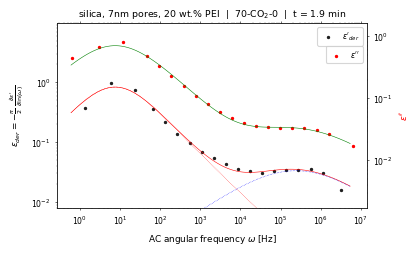

fit score 196919.0
fit parameters [2.549, 0.6502, 7.589, 0.1626, 0.451, 240400.0, 1e-10, 1.0, 1e-10]


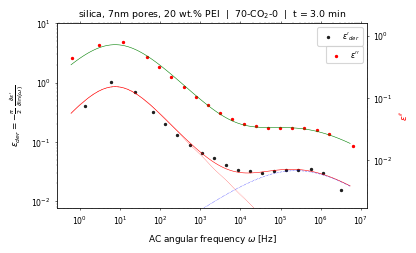

FALLBACK 2:  379458.0
fit score 236346.0
fit parameters [2.565, 0.6516, 5.545, 0.1576, 0.4367, 240400.0, 1e-10, 1.0, 1e-10]


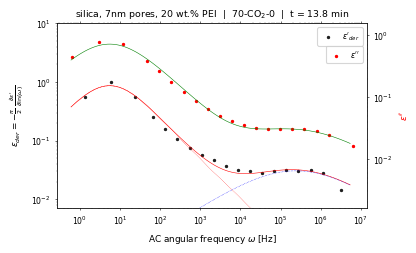

FALLBACK 2:  1603240.0
fit score 1798169.0
fit parameters [2.562, 0.6663, 4.42, 0.1746, 0.3841, 114500.0, 1e-10, 1.0, 1e-10]


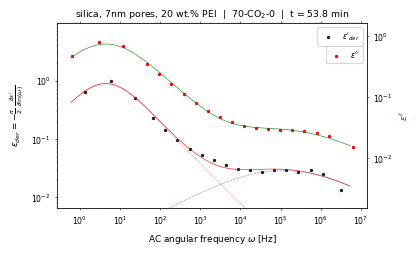

fit score 1722949.0
fit parameters [2.602, 0.6511, 3.698, 0.1639, 0.3945, 114500.0, 1e-10, 1.0, 1e-10]


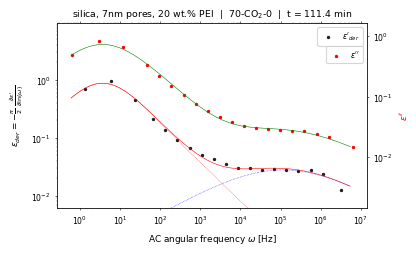

fit score 96595.0
fit parameters [2.336, 0.6247, 12.17, 0.1105, 0.5102, 271000.0, 2070000.0, 0.8213, 2.657e-09]


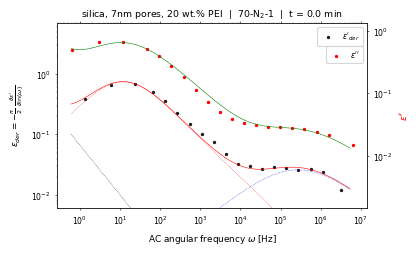

fit score 28888175.0
fit parameters [2.045, 0.7743, 208.7, 0.5432, 0.3119, 6385.0, 13190000.0, 0.8345, 6.462e-09]


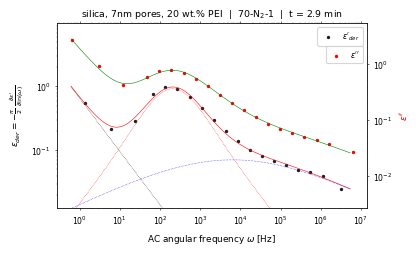

fit score 103481894.0
fit parameters [1.597, 0.7757, 511.5, 1.018, 0.3717, 5294.0, 32900000.0, 0.7887, 3.691e-09]


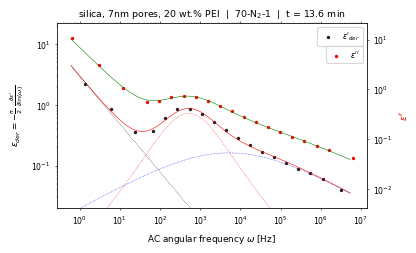

fit score 442128689.0
fit parameters [1.382, 0.7887, 782.0, 1.354, 0.3729, 6231.0, 57850000.0, 0.7717, 2.389e-09]


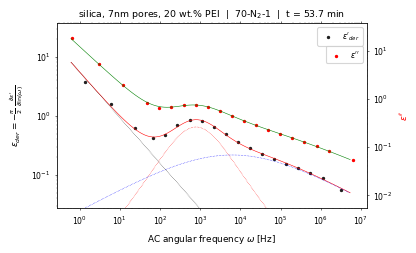

fit score 205979392.0
fit parameters [1.204, 0.814, 862.0, 1.618, 0.3734, 4044.0, 62180000.0, 0.761, 1.811e-09]


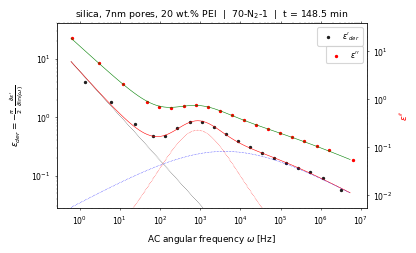

FALLBACK 1:  54360.0
fit score 54360.0
fit parameters [2.637, 0.6324, 8.194, 0.1556, 0.4768, 240400.0, 1e-10, 1.0, 1e-10]


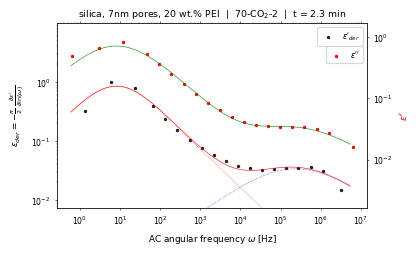

fit score 52418.0
fit parameters [2.625, 0.6511, 8.177, 0.1559, 0.4783, 240400.0, 1e-10, 1.0, 1e-10]


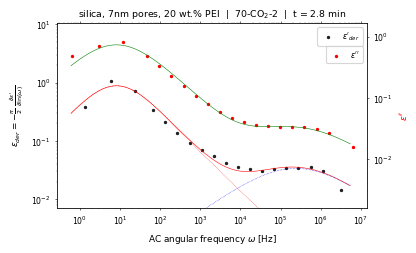

FALLBACK 1:  120440.0
FALLBACK 2:  497576.0
fit score 231046.0
fit parameters [2.535, 0.6778, 4.899, 0.1645, 0.4232, 120200.0, 1e-10, 1.0, 1e-10]


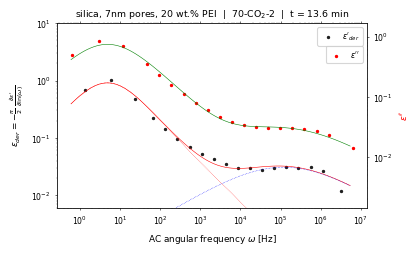

fit score 836804.0
fit parameters [2.692, 0.6449, 3.498, 0.1545, 0.4255, 120200.0, 1e-10, 1.0, 1e-10]


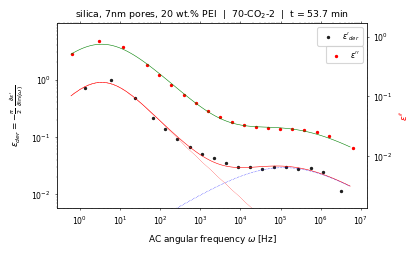

fit score 444340.0
fit parameters [2.743, 0.6286, 2.94, 0.1433, 0.4351, 120200.0, 1e-10, 1.0, 1e-10]


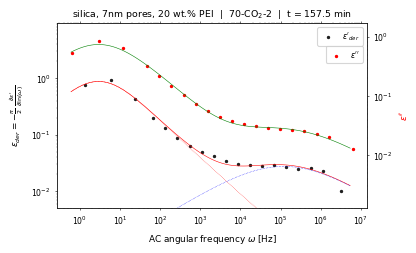

fit score 290848.0
fit parameters [4.206, 0.4148, 1.402, 0.09364, 0.5012, 552300.0, 3313000.0, 0.9983, 3.9690000000000006e-40]


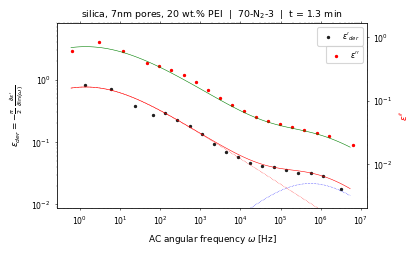

fit score 32990534.0
fit parameters [2.079, 0.7559, 159.5, 0.5371, 0.2852, 5100.0, 3579000.0, 0.8109, 1.266e-08]


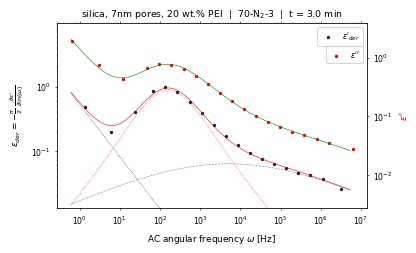

fit score 107898417.0
fit parameters [1.591, 0.7655, 471.5, 1.017, 0.359, 4513.0, 5060000.0, 0.7162, 4.367e-09]


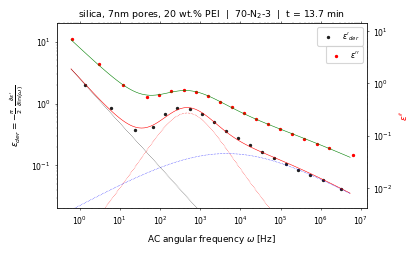

fit score 901635286.0
fit parameters [1.39, 0.7843, 750.6, 1.346, 0.3672, 6115.0, 14390000.0, 0.7357, 4.584e-09]


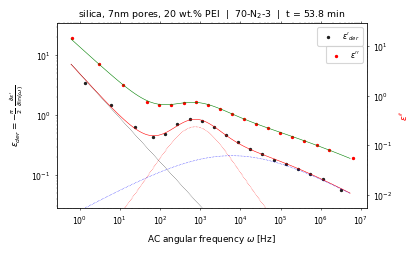

fit score 388817117.0
fit parameters [1.263, 0.802, 885.8, 1.554, 0.3695, 4720.0, 20560000.0, 0.7417, 4.336e-09]


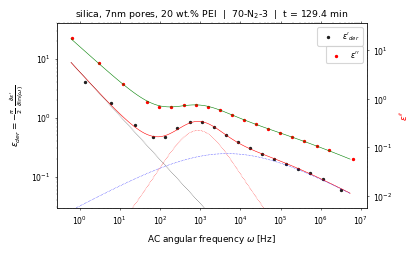

FALLBACK 1:  1551.0
fit score 2497133.0
fit parameters [1.875, 0.6573, 9.747, 0.2073, 0.3348, 35040.0, 1308000.0, 0.9995, 1.226e-07]


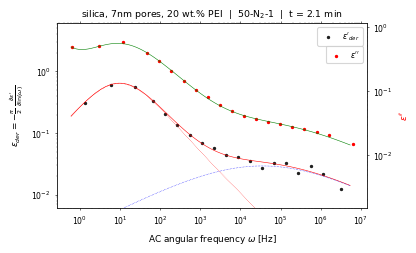

fit score 9655731.0
fit parameters [1.781, 0.7, 13.11, 0.2635, 0.296, 11950.0, 444300.0, 0.9998, 4.496e-07]


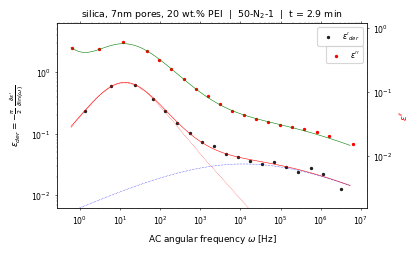

fit score 93668674.0
fit parameters [1.728, 0.712, 27.19, 0.347, 0.2611, 5829.0, 19440000.0, 0.9867, 1.472e-08]


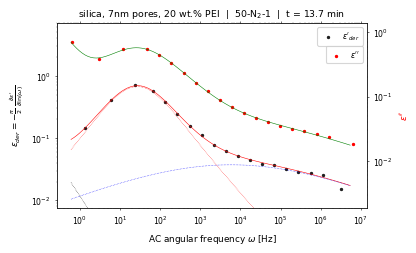

fit score 15499309.0
fit parameters [1.42, 0.7432, 89.35, 0.6032, 0.2726, 1358.0, 71980000.0, 0.8933, 1.535e-09]


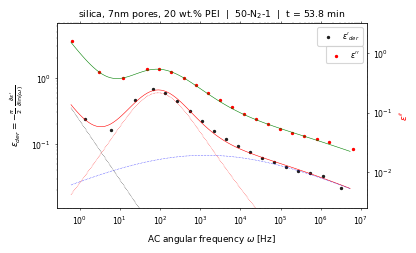

FALLBACK 1:  36711.0
fit score 6143678.0
fit parameters [1.305, 0.7574, 125.3, 0.7206, 0.3064, 1764.0, 70610000.0, 0.8665, 1.417e-09]


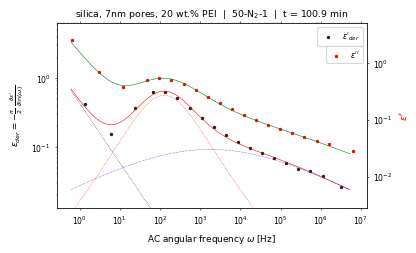

fit score 85422.0
fit parameters [0.4758, 0.6822, 97.12, 0.1826, 0.3595, 27990.0, 8367.0, 0.5842, 5.476e-07]


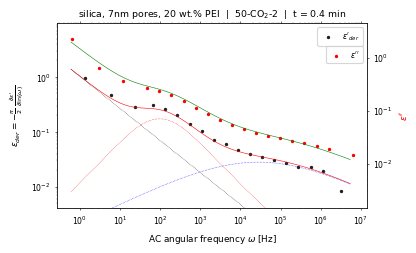

fit score 210598.0
fit parameters [0.01497, 0.8074, 1552.0, 0.101, 0.4623, 83650.0, 7832.0, 0.4546, 3.838e-09]


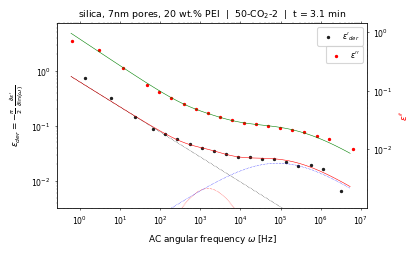

FALLBACK 2:  57198.0
fit score 289883.0
fit parameters [0.1389, 0.3271, 2000.0, 0.02649, 0.6682, 224700.0, 5443.0, 0.5188, 4.59e-08]


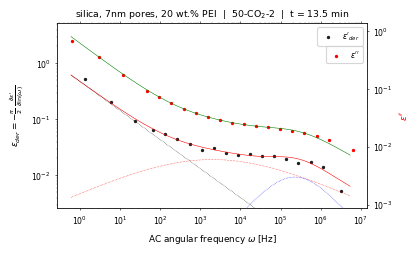

fit score 445477.0
fit parameters [0.1511, 0.3128, 2000.0, 0.02336, 0.7143, 263800.0, 12440.0, 0.5409, 1.891e-08]


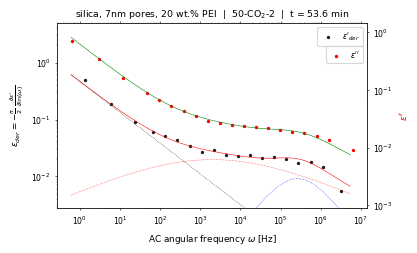

fit score 1033442.0
fit parameters [0.1578, 0.3037, 1975.0, 0.02167, 0.7423, 291900.0, 24050.0, 0.5497, 7.454e-09]


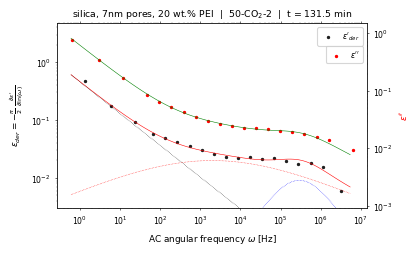

FALLBACK 1:  36340.0
fit score 36340.0
fit parameters [0.9976, 0.7824, 11.75, 0.2805, 0.2966, 2238.0, 12310000.0, 1.0, 3.316e-08]


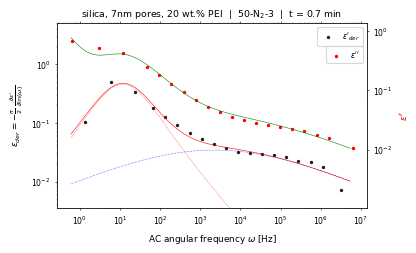

fit score 60462829.0
fit parameters [1.68, 0.7146, 13.12, 0.3059, 0.2667, 5288.0, 1573000.0, 1.0, 1.371e-07]


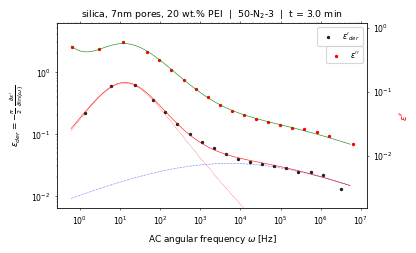

fit score 125624579.0
fit parameters [1.616, 0.7387, 25.01, 0.4222, 0.2352, 1358.0, 318600.0, 1.0, 8.607e-07]


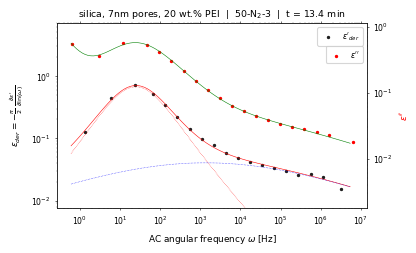

fit score 20830747.0
fit parameters [1.426, 0.7464, 79.16, 0.5967, 0.2627, 1115.0, 13700000.0, 0.903, 9.735e-09]


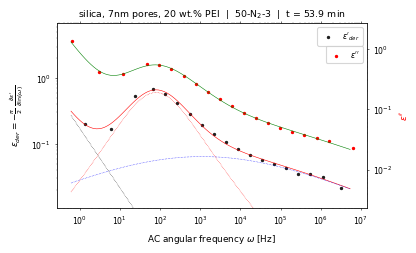

fit score 3946023374.0
fit parameters [1.883, 0.5876, 17.13, 0.4329, 0.3656, 17470.0, 18.48, 0.9999, 0.05571]


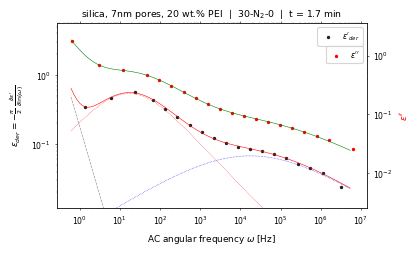

fit score 4780248443.0
fit parameters [1.886, 0.585, 18.49, 0.4254, 0.3692, 20530.0, 15.72, 1.0, 0.07289]


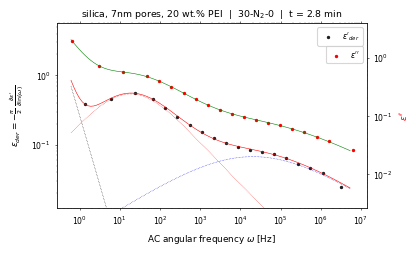

fit score 2906980534.0
fit parameters [1.9, 0.6057, 36.82, 0.426, 0.3912, 41120.0, 13.65, 1.0, 0.1859]


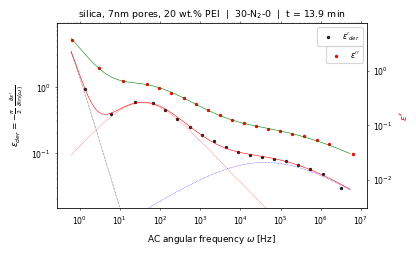

fit score 972788251.0
fit parameters [1.863, 0.6191, 68.58, 0.4049, 0.4104, 85230.0, 65.26, 0.9222, 0.06462]


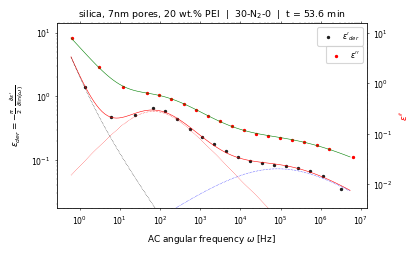

fit score 805824724.0
fit parameters [1.868, 0.6182, 68.6, 0.403, 0.4106, 87070.0, 65.06, 0.9219, 0.06519]


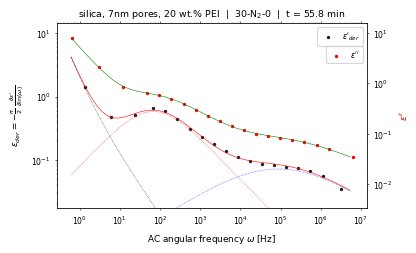

fit score 612072.0
fit parameters [0.08914, 0.7987, 1878.0, 0.1132, 0.5834, 183800.0, 7306.0, 0.5327, 6.515e-08]


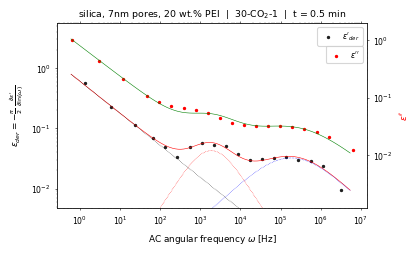

fit score 5285467.0
fit parameters [0.2814, 0.3149, 275.1, 0.04546, 0.7419, 283500.0, 8.431, 0.6746, 0.03105]


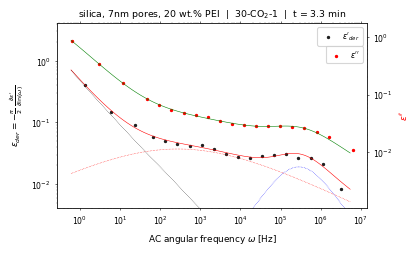

fit score 3938603.0
fit parameters [0.2497, 0.3062, 326.0, 0.03839, 0.7522, 297800.0, 128.3, 0.6647, 0.000365]


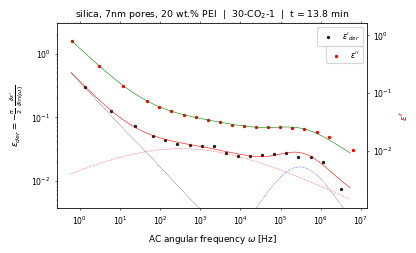

fit score 3519084.0
fit parameters [0.2583, 0.2852, 348.9, 0.02601, 0.8201, 369400.0, 6220.0, 0.7134, 2.913e-06]


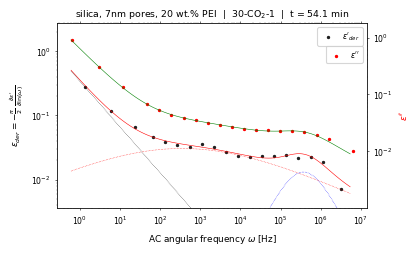

fit score 1810332.0
fit parameters [0.2816, 0.2696, 224.1, 0.02022, 0.8736, 420200.0, 10010.0, 0.7698, 4.578e-06]


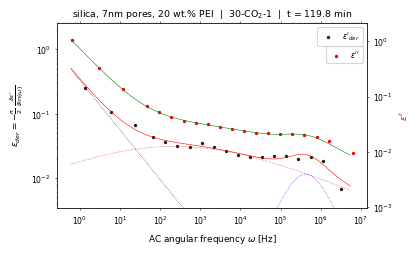

fit score 169395.0
fit parameters [0.5778, 0.7025, 5.188, 0.2808, 0.2665, 3388.0, 51500.0, 1.0, 1.296e-05]


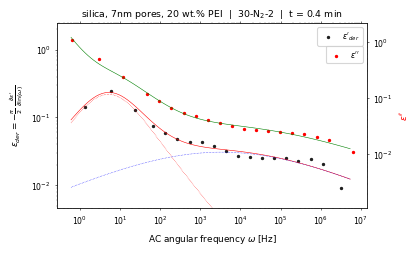

fit score 1011281.0
fit parameters [1.955, 0.6246, 1.72, 0.2675, 0.2794, 9591.0, 15910.0, 1.0, 2.57e-05]


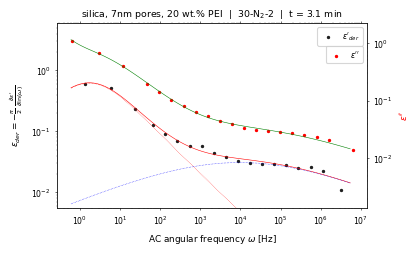

fit score 2274762.0
fit parameters [1.954, 0.6394, 3.067, 0.2498, 0.2972, 17460.0, 13300.0, 1.0, 2.283e-05]


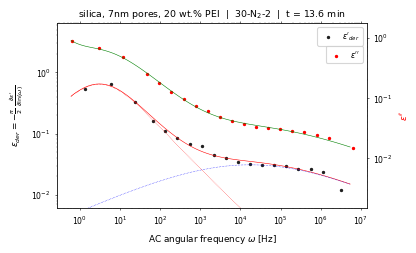

fit score 10365934.0
fit parameters [1.791, 0.6671, 7.269, 0.3114, 0.2633, 12200.0, 19890.0, 1.0, 1.908e-05]


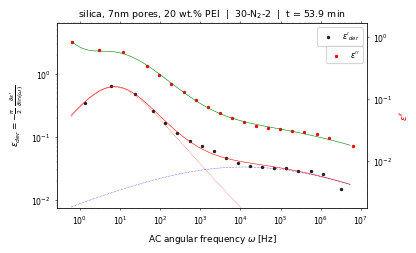

fit score 17939619.0
fit parameters [1.722, 0.6924, 13.4, 0.3781, 0.244, 7282.0, 80300.0, 1.0, 7.138e-06]


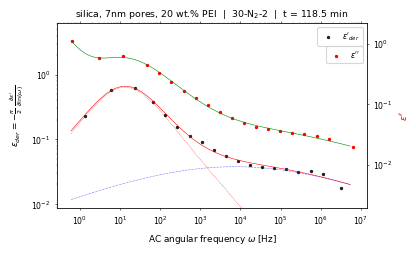

FALLBACK 1:  12121.0
fit score 394610.0
fit parameters [0.09613, 0.5757, 1101.0, 0.0767, 0.5663, 221600.0, 16010.0, 0.6042, 1.3e-07]


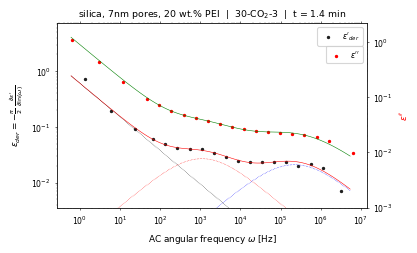

fit score 1905299.0
fit parameters [0.2193, 0.3136, 945.5, 0.02, 0.8741, 435700.0, 30590.0, 0.6479, 1.045e-07]


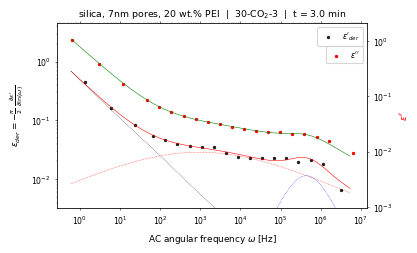

fit score 2079524.0
fit parameters [0.2425, 0.2981, 458.4, 0.02059, 0.865, 420100.0, 40160.0, 0.696, 1.733e-07]


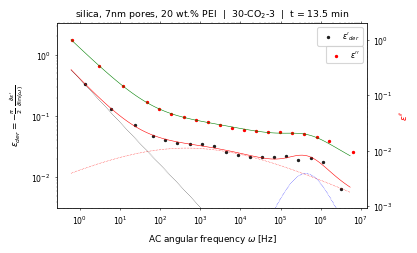

fit score 1431893.0
fit parameters [0.274, 0.2779, 255.4, 0.01895, 0.8909, 450000.0, 10870.0, 0.7605, 3.986e-06]


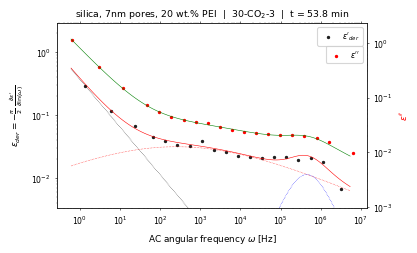

fit score 2745524.0
fit parameters [0.2925, 0.2634, 177.2, 0.01753, 0.9022, 458900.0, 14910.0, 0.7882, 4.254e-06]


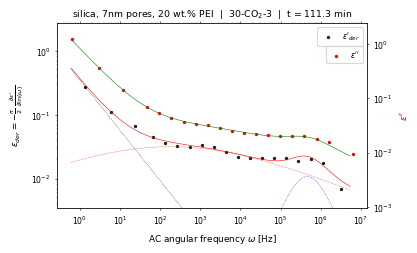

fit score 388907.0
fit parameters [1.599, 0.5401, 1.623, 0.1949, 0.3266, 29760.0, 29990.0, 1.0, 2.132e-05]


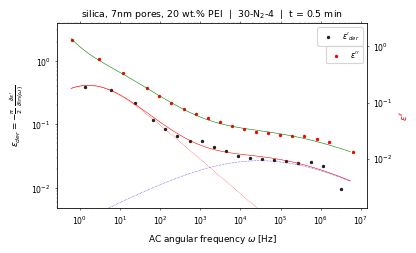

fit score 1576568.0
fit parameters [1.938, 0.6046, 3.483, 0.2466, 0.2957, 20930.0, 27260.0, 1.0, 2.144e-05]


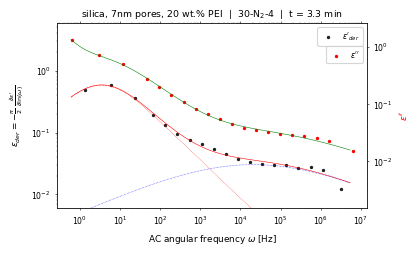

fit score 3554046.0
fit parameters [1.877, 0.6381, 7.49, 0.273, 0.2887, 22930.0, 50940.0, 1.0, 1.296e-05]


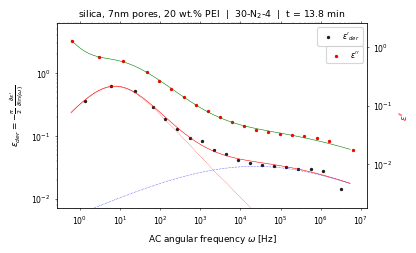

fit score 6462774.0
fit parameters [1.804, 0.6626, 11.29, 0.3055, 0.2747, 18060.0, 270800.0, 1.0, 2.425e-06]


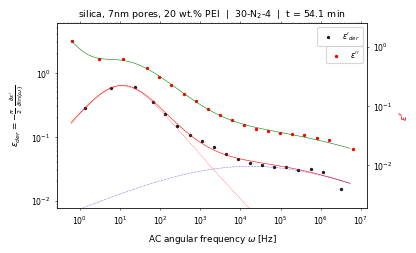

fit score 11245169.0
fit parameters [1.779, 0.6759, 14.39, 0.3413, 0.2604, 12790.0, 21870000.0, 1.0, 3.47e-08]


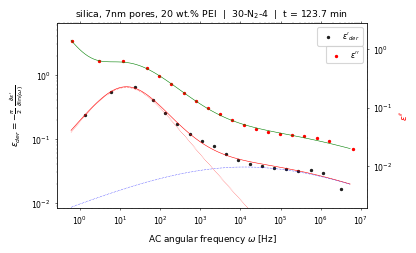

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

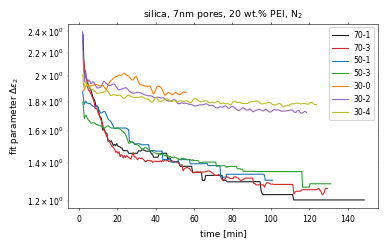

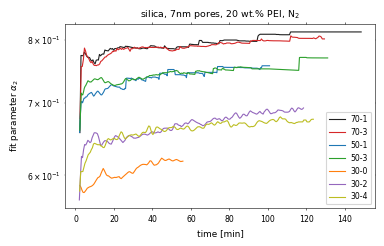

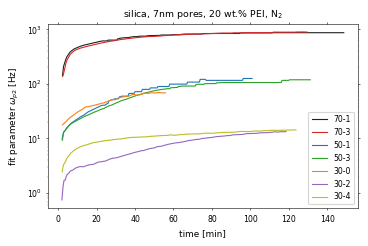

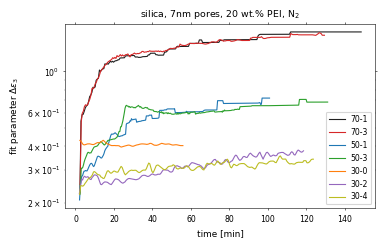

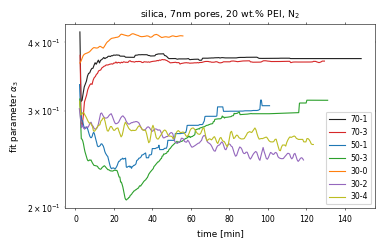

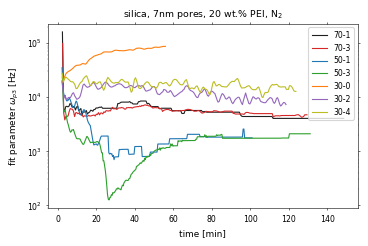

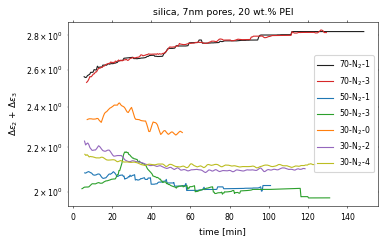

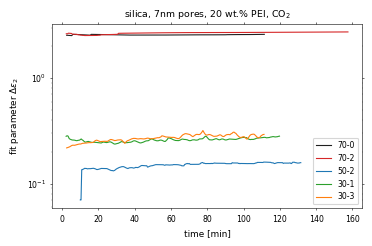

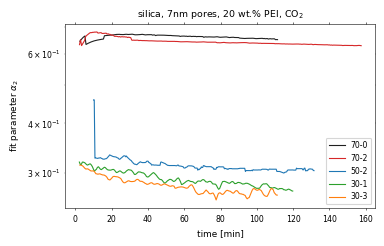

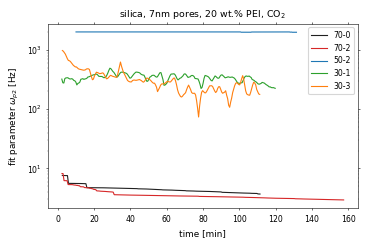

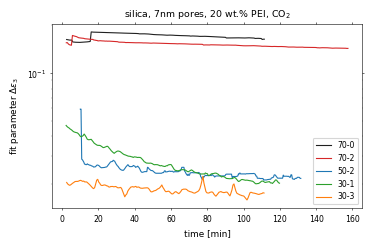

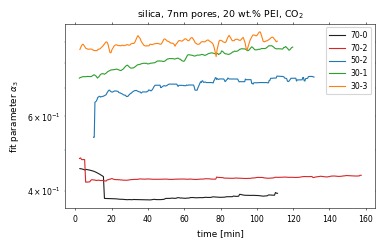

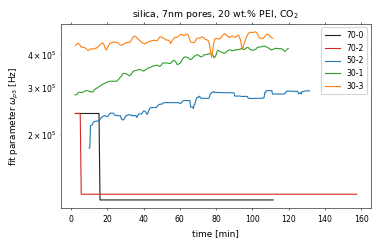

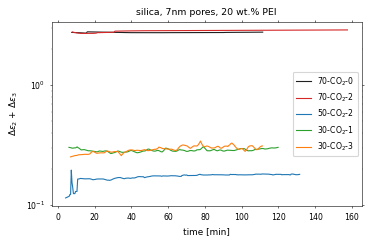

In [7]:
### Plot time evolution of fit parameters

# j: run with specific temp and gas
# i: parameters

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

p_in = [0, 2, 3, 5, 6, 8]

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, linewidth=1)
            plt.title(SAMPLE + ", " + gas)

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/paramkin/"+gas+" "+parameter+".png", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, linewidth=1)
        plt.title(SAMPLE)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


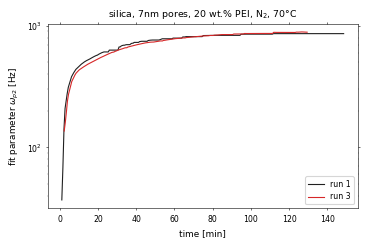

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


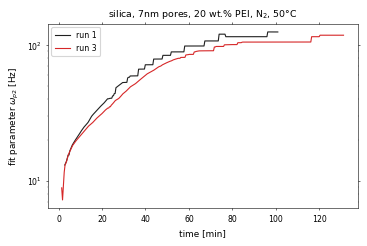

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


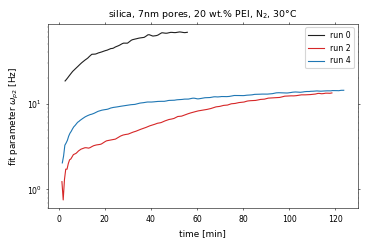

In [8]:
### parameters by temperature

def exp(x, a, b, c) :
    return np.exp(-b*(x-a)) + c

for i, parameter in enumerate(p_labels[:-3]) :
    if i != 2 :
        continue

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('log')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            t, p = DT_ALL[j][2:], P_ALL[j][i][2:]
            #n = np.argmin(a)
            #t, a = t[n:], a[n:]
            plt.plot(t, p, label=label, linewidth=1)
            fitt1 = t < 10
            fitt2 = t > 15

            fitf = exp
            try :
                ldgnd = skdfjsio
                popt1, _ = curve_fit(fitf, t[fitt1], a[fitt1], bounds=((0., 0., 0.), (i_, i_, i_)))
                popt2, _ = curve_fit(fitf, t[fitt2], a[fitt2], bounds=((0., 0., 0.), (i_, i_, i_)))

                y1 = fitf(t, *popt1)
                y2 = fitf(t, *popt2)
                #yp = expp(DT, *popt[:3])
                #yn = expn(DT, *popt[2:])
                plt.plot(t, y1, linewidth=0.5, color='b')
                plt.plot(t, y2, linewidth=0.5, color='g')
                #plt.plot(DT, yp)
                #plt.plot(DT, yn)
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.title(SAMPLE + ", " + id[3:-2] + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/omegaevo/"+gas+" "+temp+".png", bbox_inches='tight')
        plt.show()

70
[2.61800637e+02 2.96471004e+01 1.78499770e+04 4.78951339e+00
 4.39160194e+01]
70
[3.36437035e+02 3.81304898e+01 1.82268988e+04 6.00403141e+00
 5.52560141e+01]


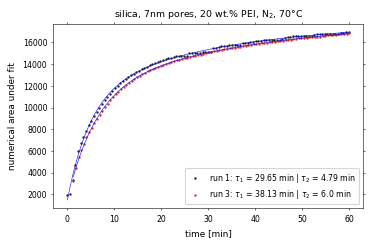

50
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
50
[5.05207690e+00 7.66007427e-01 7.33274271e+04 1.76865541e+03
 1.97612649e+04]


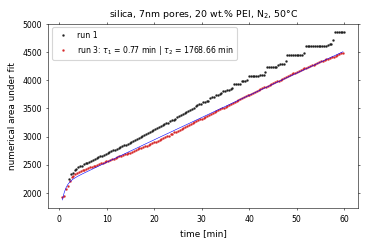

30
[-6.23871933e+04  8.58975674e+04  6.27769245e+03  1.11810106e+01
  8.09810665e+01]
30
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
30
[  20.91487944    3.41000048 2632.56386117   26.08007207  146.80208302]


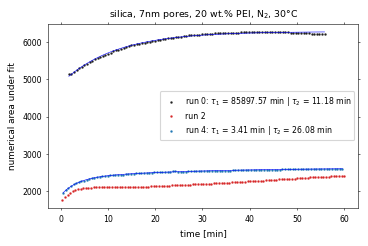

70
[ 9.52653600e+00  1.46231472e+00  1.94136780e+03  8.36773645e-02
 -2.44841401e+03]
70
[-1191.50067968    20.13646537  1897.09401989     8.3623417
    46.16497478]


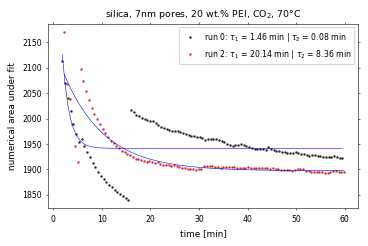

50
[4.40067522e+00 6.36194892e-01 1.32738777e+03 5.60303555e+00
 3.50924423e+01]


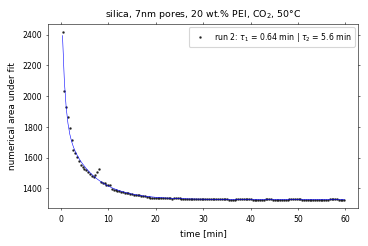

30
[ 104.07233407   18.42040567 1379.27376459    2.28954642   13.36048591]
30
[1032.2156322   228.78957885 1251.15877582    5.03069665   24.69725962]


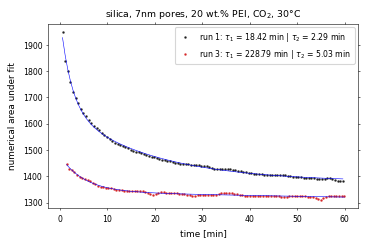

In [9]:
### Plot area

def exp(x, a, b, c, d, e) :
    return np.exp(-(x-a)/b) + c + np.exp(-(x-e)/d)
def expn(x, a, b, c, d, e) :
    return -np.exp(-(x-a)/b) + c - np.exp(-(x-e)/d)

p01 = [[3.13982775e+02, 3.54885096e+01, 1.81290828e+04, 5.70343000e+00, 5.24520412e+01],
    [1.18472451e+01, 1.11436920e+00, 1.98973972e+05, 6.78821372e+01, 7.78590720e+02],
    [1.50365926e+01, 2.43106947e+00, 2.61572150e+03, 1.94785320e+01, 1.12435019e+02]]
p02 = [[  13.43631687,    2.49961102, 1912.34579601,   15.56716046,   86.67703241],
    [2.47479126e+00, 3.42108290e-01, 1.32737618e+03, 5.26595996e+00, 3.37606163e+01],
    [  94.96847939,   16.59200303, 1383.53486793,    1.82029623,  10.93245541]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            print (temp)
            t, a = DT_ALL[j], A_ALL[j]
            fitt = t < 60
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                fitf = expn
                p0 = p01[T_i]
            else :
                fitf = exp
                p0 = p02[T_i]
            try :
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                print(popt)
                plt.plot(t, fitf(t, *popt), color="b")

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)
            plt.title(SAMPLE + ", " + gas + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20/areaevo/"+gas+" "+temp+"2.png", bbox_inches='tight')
        plt.show()

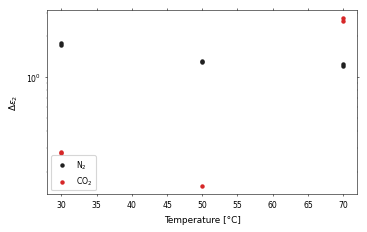

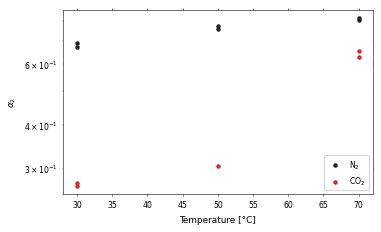

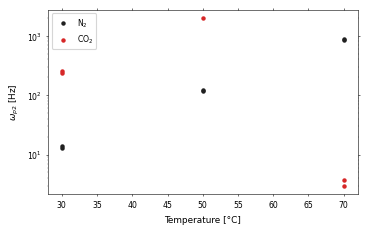

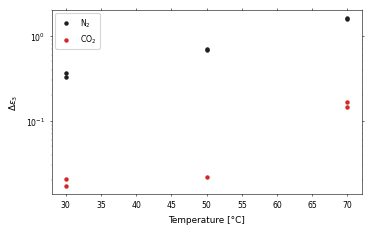

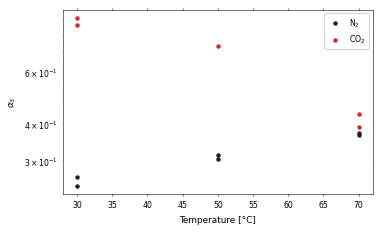

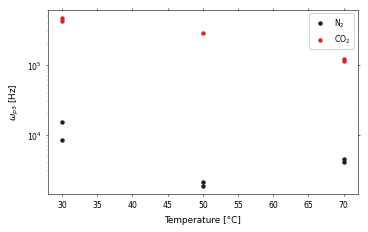

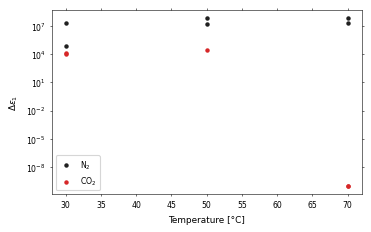

In [10]:
### plot final fit parameters against temperature

look_at = range(0,7)

for p in look_at :
    plt.yscale('log')

    for gas in GASES :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            x = P_ALL_[j][p][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        plt.scatter(v[0], v[1], linewidths=2, label=gas)
        #plt.errorbar(v[0], v[1], yerr=v[2:], fmt='none')

    plt.xlabel("Temperature [°C]")
    plt.ylabel(p_labels[p])
    plt.legend()
    plt.show()
